In [ ]:
!pip install progressbar
!pip install transliteration

  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=46c726f0c02583cba2574241359c94157e48022a5e33db6f86c66714abc37aa1
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar
     |████████████████████████████████| 849kB 4.9MB/s 
  Created wheel for transliteration: filename=transliteration-0.4.1-cp36-none-any.whl size=848954 sha256=1e67847c13ed6bae6a494fb37c61939f49e13b2a4fa5adec88190e6bd0caed96
  Stored in directory: /root/.cache/pip/wheels/79/9c/2d/52407b904883634c54376392b566005cca6b00763d6d3280f8
  Created wheel for normalizer: filename=normalizer-0.2.1-cp36-none-any.whl size=3755 sha256=65db7083576c8957272d27a43a40a0f566d0b33035ac87983aa81ab4f29072ee
  Stored in directory: /root/.cache/pip/wheels/12/bd/7d/f4333e45927815ebaae3241a46343349c0cccbc0e413b87fe5
  Created wheel for silpa-common: filename=silpa_common-0.3-cp36-none-any.whl size=8453 sha256=25c52b6baa9

In [ ]:
!pip install indic_transliteration

     |████████████████████████████████| 102kB 4.5MB/s 
     |████████████████████████████████| 911kB 10.5MB/s 
  Created wheel for splinter: filename=splinter-0.13.0-cp36-none-any.whl size=33304 sha256=19e97197dadb19fd40ba181c70c0af9dbd4c9098f8fcf549dad0d69dc0f363a4
  Stored in directory: /root/.cache/pip/wheels/fd/ff/26/2fc56897bcbe58908bbb2002c53affb516e5e6daa425aefdef
Successfully built splinter


In [ ]:
import urllib.request
import os
import zipfile
import glob
import numpy as np
import random
from keras import models
from keras import layers
from keras import callbacks
from keras.utils import plot_model
import matplotlib.pyplot as plt
import progressbar
from indic_transliteration import sanscript

Using TensorFlow backend.


In [ ]:
corpus_path = "corpus"
 
# Hyperparameters.
transliteration = True 
input_length = 40
output_length = 1 
data_set_size = 100000
num_epochs = 50 
batch_size = 256 
hidden_size = 350 
generation_length = 100 

In [ ]:
def main():
    # download corpus.
    ensure_corpus()
 
    (train_input, train_output) = load_data()
    print("train_input", train_input.shape, " ", train_output.shape)
 
    global model
    model = create_model()

    generate_callback = callbacks.LambdaCallback(on_epoch_end=on_epoch_end)
 
    history = model.fit(
        train_input, train_output,
        epochs=num_epochs, batch_size=batch_size,
        callbacks = [generate_callback]
    )
 
  
    model.save("model.h5")
 
   
    plot_history(history)

In [ ]:
def ensure_corpus():

    
    if os.path.exists("corpus") == False:
        # Download the whole git-repository as a zip.
        print("Downloading corpus...")
        corpus_url = "https://github.com/cltk/hindi_text_ltrc/archive/master.zip"
        corpus_zip_path = "master.zip"
        urllib.request.urlretrieve(corpus_url, corpus_zip_path)
 
       
        
        zip_file = zipfile.ZipFile(corpus_zip_path, 'r')
        zip_file.extractall(corpus_path)
        zip_file.close()
 
      
        os.remove(corpus_zip_path)

In [ ]:
def load_data():

    glob_path = os.path.join(corpus_path, "**/*.txt")
    paths = glob.glob(glob_path, recursive=True)

    print("Loading all files...")
    file_contents = []
    for path in paths:
        file_content = open(path, "r", encoding = "utf-8").read()
        if transliteration == True:
            file_content = sanscript.transliterate(file_content, sanscript.DEVANAGARI, sanscript.IAST)
        file_content = clean_text(file_content)
        file_contents.append(file_content)
 
    print("Getting character set...")
    global full_text
    full_text = " ".join(file_contents)
    global character_set
    character_set = get_character_set(full_text)
    print("Character set:", character_set)
 
    # Process the data.
    data_input = []
    data_output = []
    current_size = 0
    print("Generating data set...")
    bar = progressbar.ProgressBar(maxval = data_set_size)
    bar.start()
    while current_size < data_set_size:
        random_file_content = random.choice(file_contents)
        # print("random : ", random_file_content)
        random_string = random_substring_of_length(random_file_content, input_length + output_length)
 
        random_string_encoded = encode_string(random_string)
 
        input_sequence = random_string_encoded[:input_length]
        output_sequence = random_string_encoded[input_length:]
 
        data_input.append(input_sequence)
        data_output.append(output_sequence)
 
        current_size += 1
        bar.update(current_size)
    bar.finish()

    train_input = np.array(data_input)
    train_output = np.array(data_output)
    return (train_input, train_output)

In [ ]:
def clean_text(text):
    
    text = text.replace("\t", " ")
    text = text.replace("\n", " ")
    text = text.replace("।", " ")
    text = text.replace("0", " ")
    text = text.replace("1", " ")
    text = text.replace("2", " ")
    text = text.replace("3", " ")
    text = text.replace("4", " ")
    text = text.replace("5", " ")
    text = text.replace("6", " ")
    text = text.replace("7", " ")
    text = text.replace("8", " ")
    text = text.replace("9", " ")
    text = " ".join(text.split())
    
    return text

In [ ]:
def get_character_set(string):
    # get all unique characters.
    return sorted(list(set(string)))

def random_substring_of_length(string, length):
    # get random substring.
    start_index = random.randint(0, len(string) - length)
    return string[start_index:start_index + length]

In [ ]:
def encode_string(string):
    """ Encodes a string in order to use it in the Neural Network context. """
    # character_set = [' ', '!', '"', "'", '(', ')', ',', '-', '.', '/', ':', '=', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'y', 'z', '|', 'Ê', 'Ù', 'Ý', 'è', 'é', 'ê', 'í', 'ñ', 'û', 'ā', 'ġ', 'ī', 'ś', 'ū', '̐', '़', 'ॅ', 'ॉ', 'ḍ', 'ḥ', 'ḷ', 'ḻ', 'ṃ', 'ṅ', 'ṇ', 'ṛ', 'ṝ', 'ṣ', 'ṭ', '\u200c', '\u200d', '–', '’']
    encoded_string = []
    for character in string:
        encoded_character = np.zeros((len(character_set),))
        one_hot_index = character_set.index(character)
        encoded_character[one_hot_index] = 1.0
        encoded_string.append(encoded_character)
    return np.array(encoded_string)

In [ ]:
def create_model():

    input_shape = (input_length, len(character_set))
 
    model = models.Sequential()
    model.add(layers.LSTM(hidden_size, input_shape=input_shape, activation="relu"))
    model.add(layers.Dense(output_length * len(character_set), activation="relu"))
    model.add(layers.Reshape((output_length, len(character_set))))
    model.add(layers.TimeDistributed(layers.Dense(len(character_set), activation="softmax")))
    model.summary()
 
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
 
    return model

In [ ]:
def plot_history(history):

    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("accuracy.png")
    plt.clf()

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("loss.png")

In [ ]:
def on_epoch_end(epoch, logs):

    if epoch % 10 == 0 and epoch != 0:
        print("")
 
        for temperature in [0.0, 0.25, 0.5, 0.75, 1.0]:
            # print("Temperature:", temperature)
            global full_text
            random_string = random_substring_of_length(full_text, input_length)
            result_string = random_string
            print("Seed string:  ", sanscript.transliterate(random_string, sanscript.IAST, sanscript.DEVANAGARI))
            input_sequence = encode_string(random_string)
 
            
            while len(result_string) < generation_length:
                output_sequence = model.predict(np.expand_dims(input_sequence, axis=0))
                output_sequence = output_sequence[0]
                decoded_string = decode_sequence(output_sequence, temperature)
                output_sequence = encode_string(decoded_string)
                result_string += decoded_string
                input_sequence = input_sequence[output_length:]
                input_sequence = np.concatenate((input_sequence, output_sequence), axis=0)
 
            print("Result string:", sanscript.transliterate(result_string, sanscript.IAST, sanscript.DEVANAGARI), len(result_string))

In [ ]:
generate_callback = callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
def decode_sequence(sequence, temperature=0.0):

    result_string = ""
    for element in sequence:
        index = get_index_from_prediction(element)
        character = character_set[index]
        result_string += character
    return result_string

In [ ]:
def get_index_from_prediction(prediction, temperature=0.0):

   
    if temperature == 0.0:
        return np.argmax(prediction)
 
   
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)

Loading all files...


Getting character set...
Character set: [' ', '!', '"', "'", '(', ')', ',', '-', '.', '/', ':', '=', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'y', 'z', '|', 'Ê', 'Ù', 'Ý', 'è', 'é', 'ê', 'í', 'ñ', 'û', 'ā', 'ġ', 'ī', 'ś', 'ū', '̐', '़', 'ॅ', 'ॉ', 'फ़', 'ḍ', 'ḥ', 'ḷ', 'ḻ', 'ṃ', 'ṅ', 'ṇ', 'ṛ', 'ṝ', 'ṣ', 'ṭ', '\u200c', '\u200d', '–', '’']
Generating data set...


train_input (100000, 40, 73)   (100000, 1, 73)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 350)               593600    
_________________________________________________________________
dense_1 (Dense)              (None, 73)                25623     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 73)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 73)             5402      
Total params: 624,625
Trainable params: 624,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
100000/100000 [==============================] - 59s 592us/step - loss: 3.1145 - accuracy: 0.2416
Epoch 2/50
100000/100000 [==============================] - 58s 577us/step - loss: 2.3099 

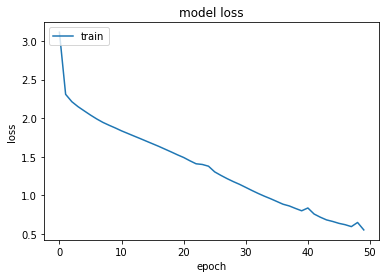

In [ ]:
main()